In [349]:
import numpy as np
import depthai as dai
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt

In [350]:
def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    plt.figure(figsize=(12, 8))
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.imshow(image)



In [351]:
!ls dataset_arm_003/left

!ls dataset-one-shot-007/left
!ls dataset-one-shot-007-2/left

left_p0_0.png	 left_p12_37.png  left_p3_9.png   left_p7_21.png
left_p0_1.png	 left_p12_38.png  left_p4_12.png  left_p7_22.png
left_p0_2.png	 left_p1_3.png	  left_p4_13.png  left_p7_23.png
left_p10_30.png  left_p1_4.png	  left_p4_14.png  left_p8_24.png
left_p10_31.png  left_p1_5.png	  left_p5_15.png  left_p8_25.png
left_p10_32.png  left_p2_6.png	  left_p5_16.png  left_p8_26.png
left_p11_33.png  left_p2_7.png	  left_p5_17.png  left_p9_27.png
left_p11_34.png  left_p2_8.png	  left_p6_18.png  left_p9_28.png
left_p11_35.png  left_p3_10.png   left_p6_19.png  left_p9_29.png
left_p12_36.png  left_p3_11.png   left_p6_20.png
left_p0_0.png
left_p0_0.png  left_p0_1.png  left_p0_2.png


## Read left and right Image

(1200, 1920, 3)


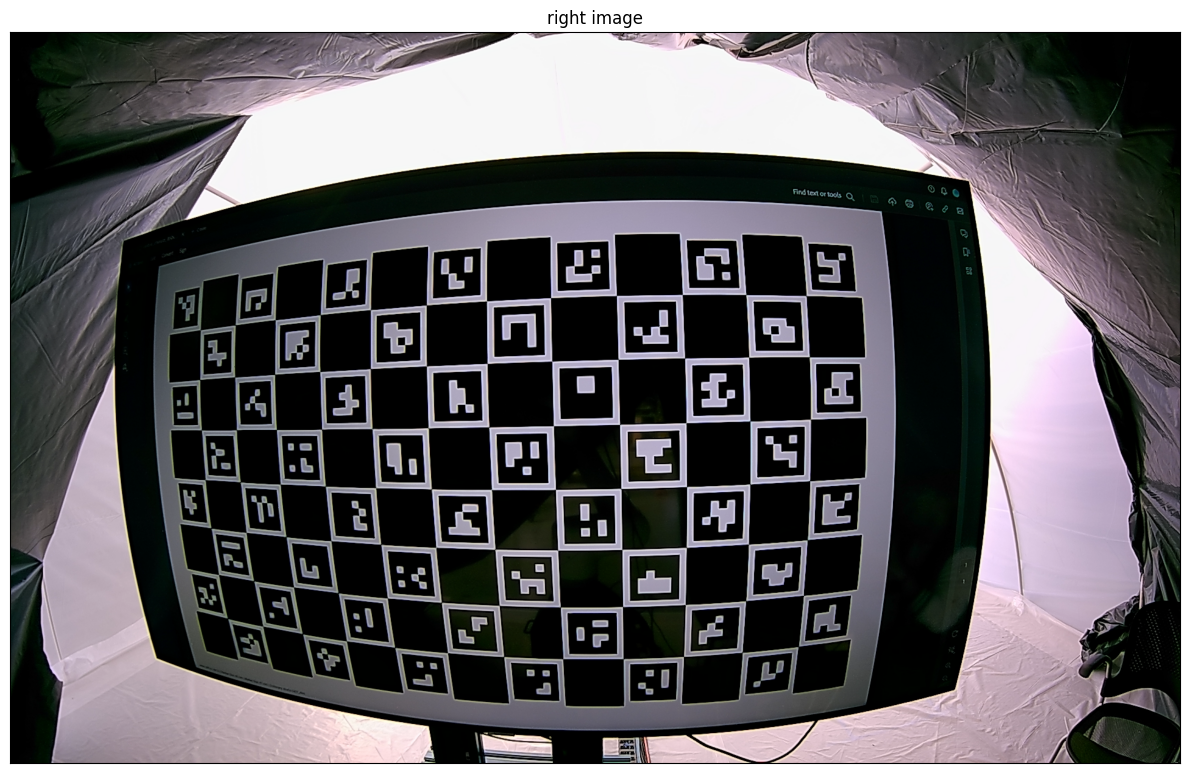

In [352]:
folder_name = "./dataset-one-shot-007"
left_image = cv2.imread(folder_name + '/left/left_p0_0.png')
right_image = cv2.imread(folder_name + '/right/right_p0_0.png')
show_rgb_image(left_image, 'Left Image')
show_rgb_image(right_image, 'right image')
print(left_image.shape)

# Read the calibration data and undistort the images

In [353]:
calibration_handler = dai.CalibrationHandler('./calib_sensus_07.json')
size = (1920, 1200)
M_left = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoLeftCameraId(), size[0], size[1]))
M_right = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoRightCameraId(), size[0], size[1]))
D_left = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoLeftCameraId()))
D_right = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoRightCameraId()))

transform = np.array(calibration_handler.getCameraExtrinsics(calibration_handler.getStereoRightCameraId(), calibration_handler.getStereoLeftCameraId())) 
R1 = np.array(calibration_handler.getStereoLeftRectificationRotation())
R2 = np.array(calibration_handler.getStereoRightRectificationRotation())

In [354]:
M_focal = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(M_right, D_right, size, np.eye(3), fov_scale=1.25)
mapXL, mapYL = cv2.fisheye.initUndistortRectifyMap(M_left, D_left[:4], R1, M_focal, size, cv2.CV_32FC1)
mapXR, mapYR = cv2.fisheye.initUndistortRectifyMap(M_right, D_right[:4], R2, M_focal, size, cv2.CV_32FC1)


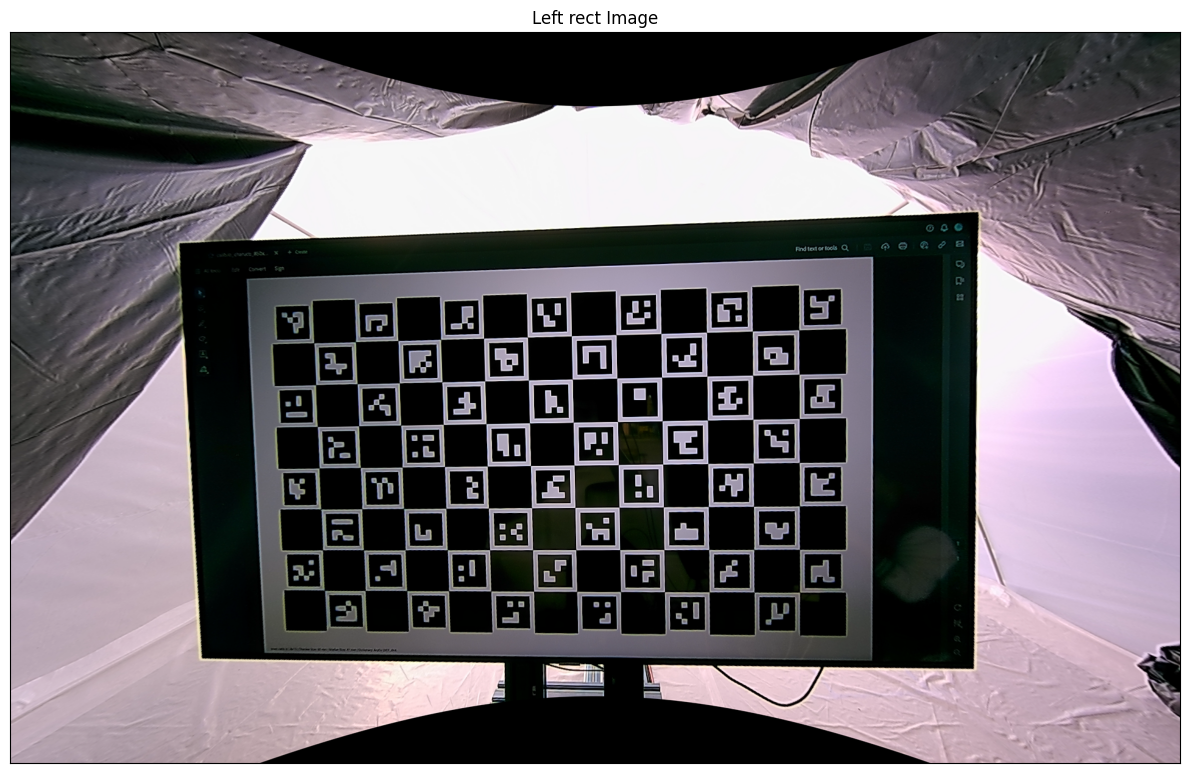

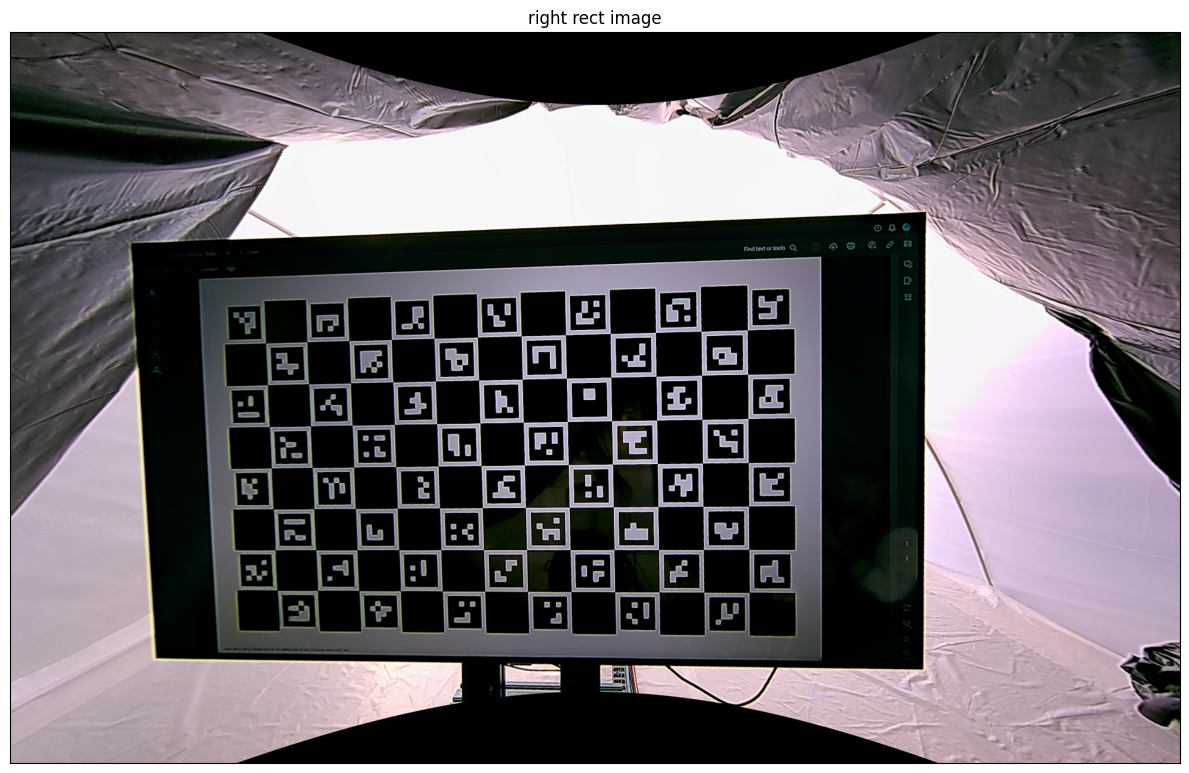

In [356]:
left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
cv2.imwrite('left_0.png', left_rect)
show_rgb_image(left_rect, 'Left rect Image')
show_rgb_image(right_rect, 'right rect image')

## Detect corners

In [10]:
aruco_dictionary = aruco.Dictionary_get(aruco.DICT_4X4_1000)
board = aruco.CharucoBoard_create(
            13, 8,
            8.1,
            6.4,
            aruco_dictionary)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.00001)
def detectMarkers(image_rgb):
    image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    marker_corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dictionary)
    
    marker_corners, ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(image, board, marker_corners, ids, rejectedCorners=rejectedImgPoints)
    res2 = cv2.aruco.interpolateCornersCharuco(
                    marker_corners, ids, image, board)

    if res2[1] is not None and res2[2] is not None and len(res2[1]) > 3:
        cv2.cornerSubPix(image, res2[1],
                                     winSize=(5, 5),
                                     zeroZone=(-1, -1),
                                     criteria=criteria)
        return res2[1], res2[2], marker_corners, ids
    else:
        return None, None, marker_corners, ids


In [11]:
chess_corners_left, chess_ids_left, marker_corners_left, ids_left = detectMarkers(left_rect)
chess_corners_right, chess_ids_right, marker_corners_right, ids_right = detectMarkers(right_rect)

## Draw markers

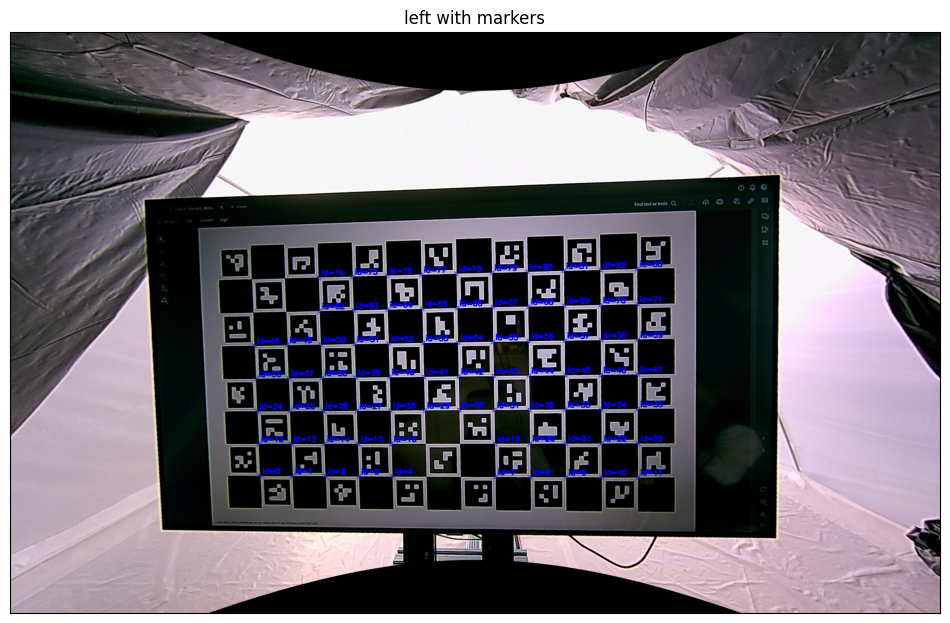

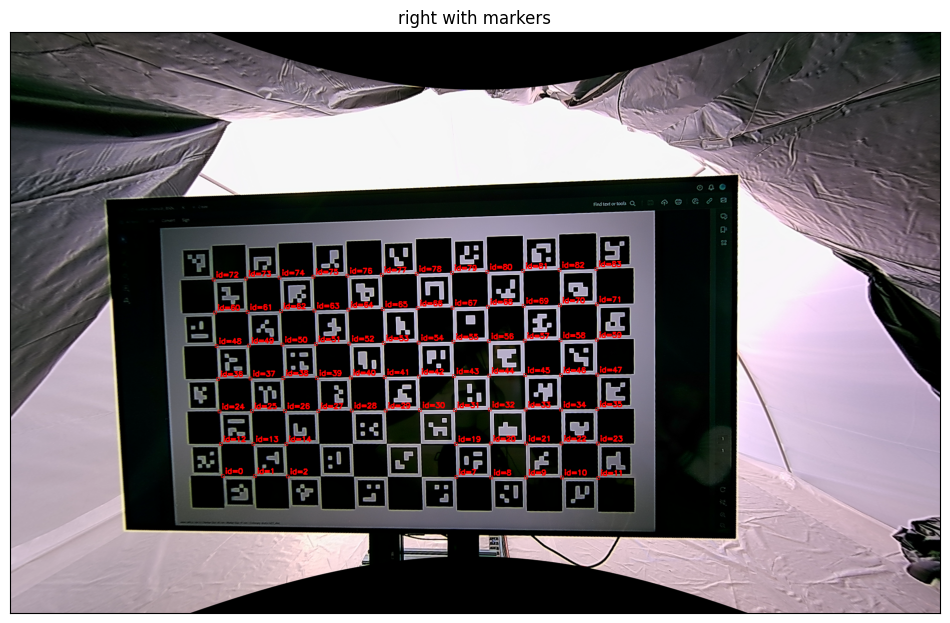

In [12]:
left_rect_marked = left_rect.copy()
# cv2.aruco.drawDetectedMarkers(left_rect_marked, marker_corners_left, ids_left, (0, 255, 0))
left_rect_marked = cv2.aruco.drawDetectedCornersCharuco(left_rect_marked, chess_corners_left, chess_ids_left, (255, 0, 0))

right_rect_marked = right_rect.copy()
# cv2.aruco.drawDetectedMarkers(right_rect_marked, marker_corners_right, ids_right, (0, 255, 0))
right_rect_marked = cv2.aruco.drawDetectedCornersCharuco(right_rect_marked, chess_corners_right, chess_ids_right, (0, 0, 255))

show_rgb_image(left_rect_marked, "left with markers")
show_rgb_image(right_rect_marked, "right with markers")

# show_rgb_image(left_rect, "left without")

### Next step is to show the lines of the markers and get the disparity between the markers. 

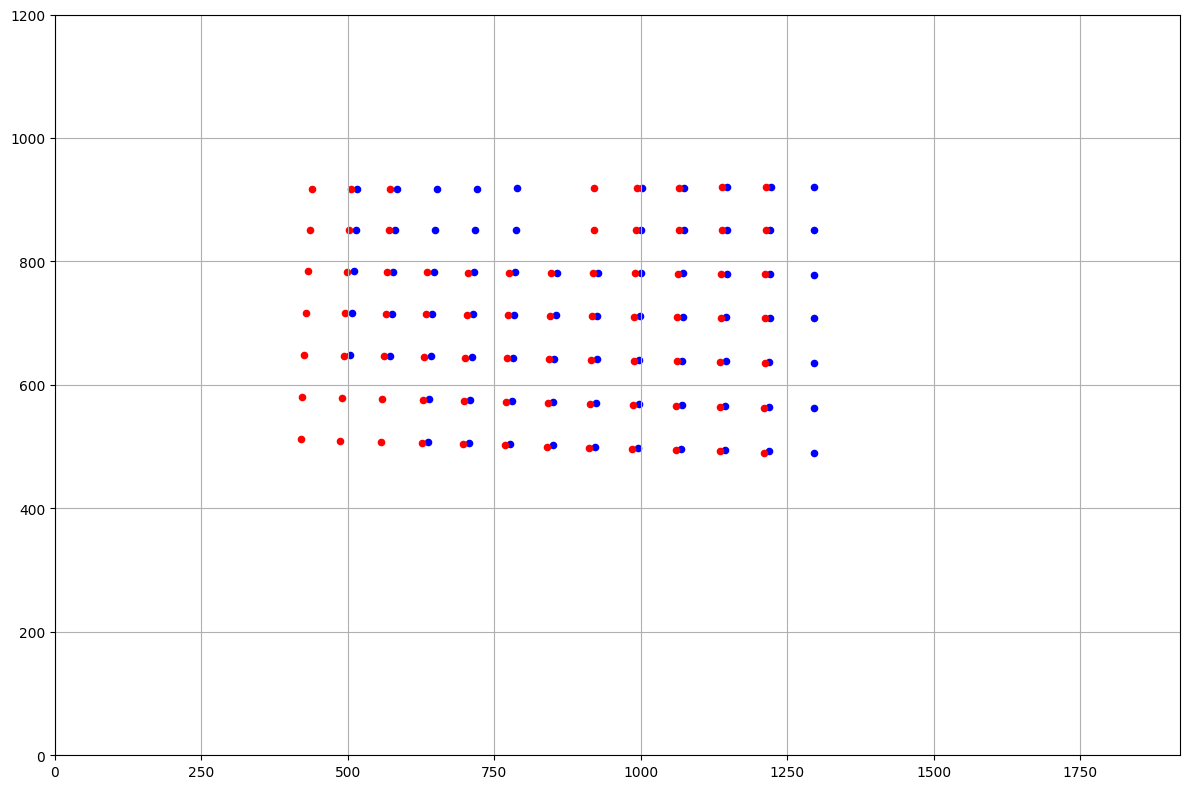

In [297]:
def display_overlay_points(left_pts, right_pts, markerSize = 20):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    plt.xlim(0, size[0])
    plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()

display_overlay_points(reshaped_chess_corners_left[None], reshaped_chess_corners_right[None])
    

In [281]:
one_pts = board.chessboardCorners
left_corners_sampled = []
right_corners_sampled = []
obj_pts = []


for j in range(len(chess_ids_left)):
    idx = np.where(chess_ids_right == chess_ids_left[j])
    if idx[0].size == 0:
        continue
    left_corners_sampled.append(chess_corners_left[j][0])
    right_corners_sampled.append(chess_corners_right[idx][0])
    obj_pts.append(one_pts[chess_ids_left[j]])
print(len(left_corners_sampled))



72


In [282]:
list_disparity = []
left_corners_sampled = np.array(left_corners_sampled)
right_corners_sampled = np.array(right_corners_sampled)
for i in range(len(left_corners_sampled)):
    list_disparity.append(left_corners_sampled[i][0] - right_corners_sampled[i][0])  
# list_disparity

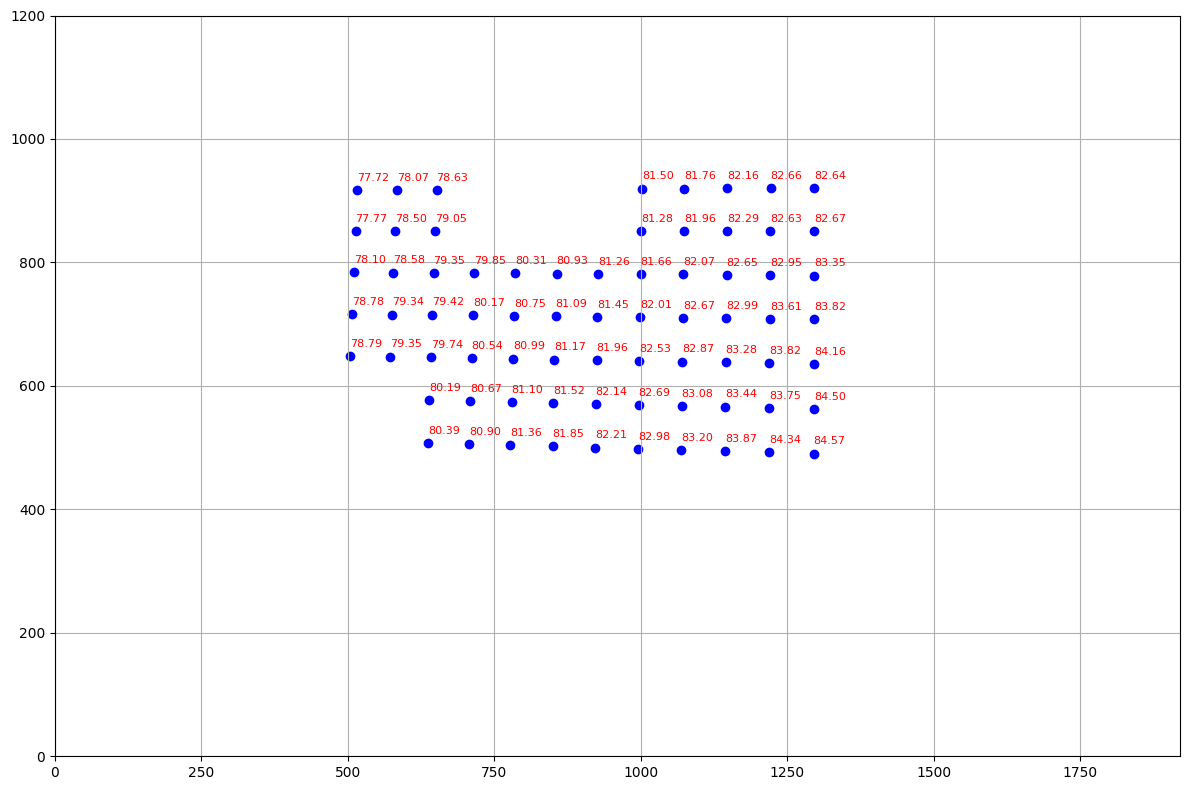

In [283]:
plt.figure(figsize=(12, 8))
plt.rcParams["figure.autolayout"] = True
plt.xlim(0, size[0])
plt.ylim(0, size[1])
plt.grid()

# corners_shape_left = chess_corners_left.shape
# reshaped_chess_corners_left = chess_corners_left.reshape(corners_shape_left[0], corners_shape_left[2])
x = left_corners_sampled[:, 0]
y = left_corners_sampled[:, 1]
color = "blue"
plt.scatter(x, y, c=color)

for i in range(left_corners_sampled.shape[0]):
    x_pos = left_corners_sampled[i][0]
    y_pos = left_corners_sampled[i][1] + 15
    # val = str(list_disparity[i])
    val = f"{list_disparity[i]:.2f}"
    plt.text(x = x_pos, y = y_pos, s=val, 
          fontdict=dict(color='red',size=8))

# Creating custom 3D points, distort them followed by undisort and check the alignment

In [284]:
x, y = np.mgrid[-250 : 250 : 60j, -100 : 100 : 60j]
positions = np.vstack([x.ravel(), y.ravel()]).T
z_axis = np.ones((positions.shape[0], 1)) * 100
points_3d = np.hstack([positions, z_axis])
points_3d = points_3d.astype(np.float32)

rot = np.eye(3, dtype = np.float32)
rvec, _ = cv2.Rodrigues(rot)
left_points_2d, _ = cv2.fisheye.projectPoints(points_3d[None], rvec, np.zeros(3), M_left, D_left)

rot = transform[:3, :3]
t = transform[:3, 3]
rvec, _ = cv2.Rodrigues(rot)
right_points_2d, _ = cv2.fisheye.projectPoints(points_3d[None], rvec, t, M_right, D_right)


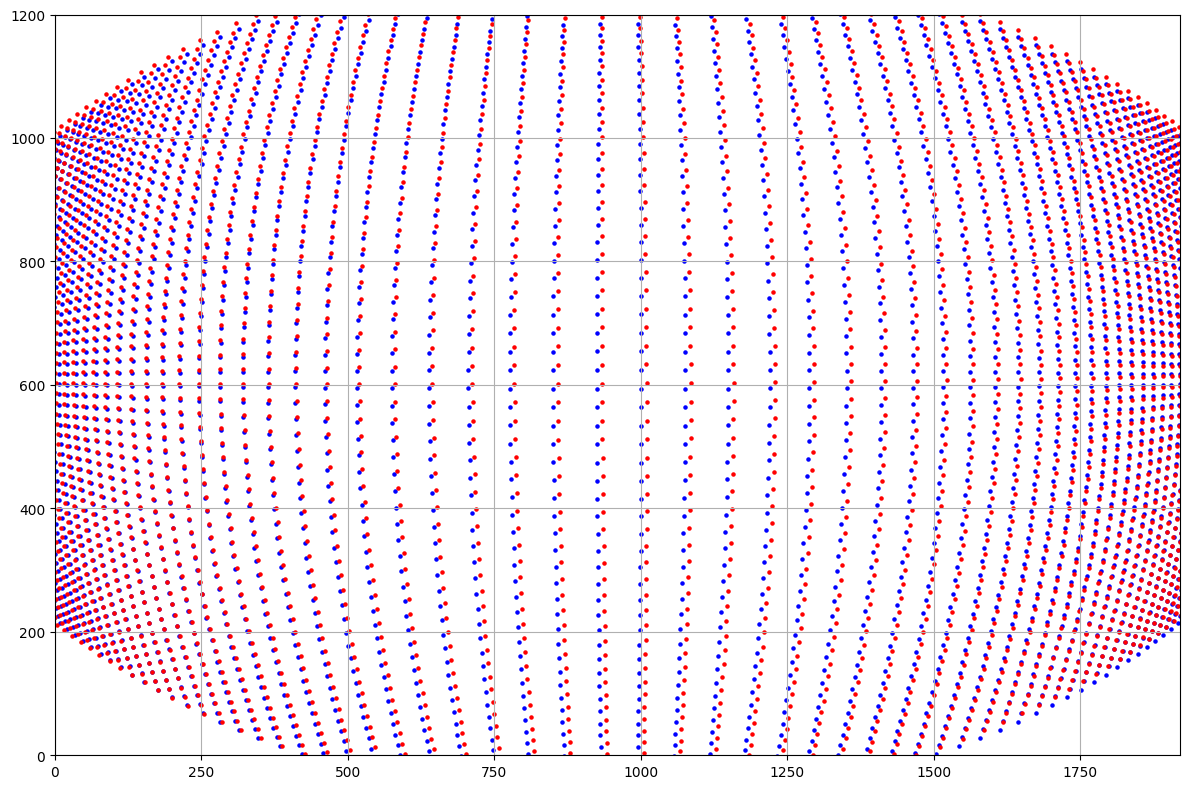

In [310]:
display_overlay_points(left_points_2d, right_points_2d, 5)

In [287]:
image = np.zeros((size[1], size[0], 3), dtype=np.uint8)
left_image = np.zeros((size[1], size[0], 3), dtype=np.uint8)
right_image = np.zeros((size[1], size[0], 3), dtype=np.uint8)

for i in range(left_points_2d.shape[1]):
    cv2.circle(image, (int(left_points_2d[0][i][0]), int(left_points_2d[0][i][1])), radius=2, color=(255, 0, 0), thickness=-1)  # -1 thickness means the circle will be filled
    cv2.circle(left_image, (int(left_points_2d[0][i][0]), int(left_points_2d[0][i][1])), radius=2, color=(255, 0, 0), thickness=-1)  # -1 thickness means the circle will be filled
    
    cv2.circle(image, (int(right_points_2d[0][i][0]), int(right_points_2d[0][i][1])), radius=2, color=(0, 0, 255), thickness=-1)  # -1 thickness means the circle will be filled
    cv2.circle(right_image, (int(right_points_2d[0][i][0]), int(right_points_2d[0][i][1])), radius=2, color=(0, 0, 255), thickness=-1)  # -1 thickness means the circle will be filled

show_rgb_image(image)
# show_rgb_image(right_image)


# It's time to undistort rectify the above

In [288]:
left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)

In [289]:
show_rgb_image(left_rect, "Left rect")
show_rgb_image(right_rect, "right rect")

In [303]:
left_undistorted_points = cv2.fisheye.undistortPoints(left_points_2d, M_left, D_left, R = R1, P = M_focal)
right_undistorted_points = cv2.fisheye.undistortPoints(right_points_2d, M_right, D_right, R = R2, P = M_focal)
display_overlay_points(left_undistorted_points, right_undistorted_points, 3)

In [321]:
list_disparity = []
for i in range(right_undistorted_points.shape[1]):
    list_disparity.append(left_undistorted_points[0][i][0] - right_undistorted_points[0][i][0])

list_disparity = np.array(list_disparity)

In [348]:
plt.hist(list_disparity, bins=25, edgecolor='black')
plt.show()


In [346]:
max_val = np.percentile(np.array(list_disparity), 85)
min_val = np.percentile(np.array(list_disparity), 10)
indicies = np.where((list_disparity > max_val) | (list_disparity < min_val))
print(max_val, min_val)

-45.571040344238284 -61.198551940917966


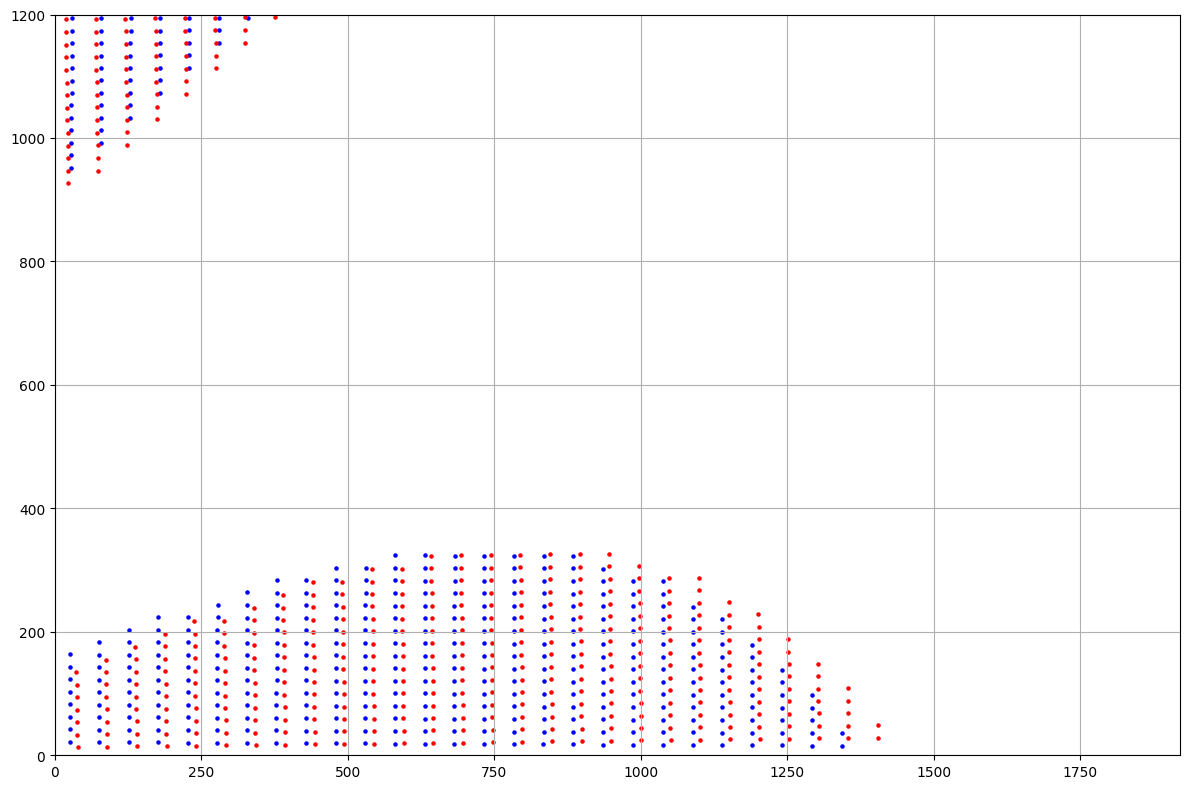

In [347]:
left_undistorted_points_edges = left_undistorted_points[0, indicies ]
right_undistorted_points_edges = right_undistorted_points[0, indicies ]

display_overlay_points(left_undistorted_points_edges, right_undistorted_points_edges, 5)

## Read the P1 and P2 from stereoRectify and see if they do a better job

In [158]:
np.array([[1, 2, 5],
                      [2, 3, 7]], dtype=np.float32)

array([[1., 2., 5.],
       [2., 3., 7.]], dtype=float32)

In [170]:
import numpy as np
import cv2

# Define the intrinsic camera matrix K
focal_length = 800  # example value
cx, cy = 320, 240  # example values for the optical center
K = np.array([[focal_length, 0, cx],
              [0, focal_length, cy],
              [0, 0, 1]])

# Define distortion coefficients
# Five distortion coefficients for the "plumb bob"/"equidistant" model
dist_coeffs = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001])  # example values

# Define 3D points in world coordinates
points_3d = np.array([[1, 2, 5],
                      [2, 3, 7],
                      [3, 4, 6]], dtype=np.float32)

# Project the 3D points into the image plane
points_2d, _ = cv2.fisheye.projectPoints(points_3d, np.eye(3), np.zeros(3), K, dist_coeffs)

# The projected points are returned in a 1xNx1x2 array
points_2d = points_2d[0, :, 0, :]

print(points_2d)

error: OpenCV(4.5.5) /io/opencv/modules/calib3d/src/fisheye.cpp:77: error: (-215:Assertion failed) objectPoints.type() == CV_32FC3 || objectPoints.type() == CV_64FC3 in function 'projectPoints'
